# Get 6C Data for Event

Get 6C data for ROMY and store it

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt

from numpy import where
from andbro__read_sds import __read_sds

from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.load_lxx import __load_lxx
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
def __write_stream_to_sds(st, cha, path_to_sds):

    import os

    # check if output path exists
    if not os.path.exists(path_to_sds):
        print(f" -> {path_to_sds} does not exist!")
        return

    tr = st.select(channel=cha)[0]

    nn, ss, ll, cc = tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel
    yy, jj = tr.stats.starttime.year, str(tr.stats.starttime.julday).rjust(3,"0")

    st.write(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D/"+f"{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}", format="MSEED")

    print(f" -> stored stream as: {yy}/{nn}/{ss}/{cc}.D/{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}")

In [4]:
def __mlti_intervals_to_zero(dat, times, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where, full, array

    dat = array(dat)

    mask = full((len(times)), 1, dtype=int)

    idx = 0
    for nn, tt in enumerate(times):

        if idx >= len(mlti_t1):
            continue
        else:
            t1, t2 = (mlti_t1[idx]-t_offset_sec), (mlti_t2[idx]+t_offset_sec)

        if tt >= t1:
            mask[nn] = 0
        if tt > t2:
            idx += 1

    dat = where(mask == 1, 1, dat)

    return dat

In [5]:
def __get_trace(seed):

    from numpy import zeros

    net, sta, loc, cha = seed.split('.')

    trr = obs.Trace()
    trr.stats.starttime = config['t1']
    trr.data = zeros(config['Nexpected'])
    trr.stats.network = net
    trr.stats.station = sta
    trr.stats.location = loc
    trr.stats.channel = cha
    trr.stats.sampling_rate = config['sampling_rate']

    return trr

## Configurations

In [6]:
config = {}

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_sds_out'] = archive_path+"temp_archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

config['tbeg'] = obs.UTCDateTime("2024-05-23")
config['tend'] = config['tbeg'] + 86400

config['sampling_rate'] = 20 # Hz

config['time_offset'] = 60 # seconds

config['t1'] = config['tbeg']-config['time_offset']
config['t2'] = config['tend']+config['time_offset']

config['Nexpected'] = int((config['t2'] - config['t1']) * config['sampling_rate'])


## Load Data

In [7]:
# load MLTI logs
mltiU = __load_mlti(config['t1'], config['t2'], "U", archive_path)
mltiV = __load_mlti(config['t1'], config['t2'], "V", archive_path)
mltiZ = __load_mlti(config['t1'], config['t2'], "Z", archive_path)

# load maintenance file
lxx = __load_lxx(config['t1'], config['t2'], archive_path)


#### Load inventory

In [8]:
romy_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

In [9]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['t1'], config['t2'])

# remove sensitivity
st0 = st0.remove_sensitivity(romy_inv)

print(st0)

# check if merging is required
if len(st0) > 3:
    print(f" -> merging required!")
    st0.merge(fill_value="interpolate")

print(st0)

# remove trend
st0 = st0.detrend("linear")

# check if data has same length
for tr in st0:
    Nreal = len(tr.data)
    if Nreal != config['Nexpected']:
        tr.data = tr.data[:config['Nexpected']]
        # print(f" -> adjust length: {tr.stats.station}.{tr.stats.channel}:  {Nreal} -> {config['Nexpected']}")

rot_zne = __rotate_romy_ZUV_ZNE(st0, romy_inv, keep_z=True)

# st0 = st0.trim(config['tbeg'], config['tend'])

st0

7 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-05-22T23:59:00.009800Z - 2024-05-24T00:01:00.009800Z | 20.0 Hz, 1730401 samples
BW.ROMY..BJU   | 2024-05-22T23:59:00.011399Z - 2024-05-23T13:23:12.811399Z | 20.0 Hz, 965057 samples
BW.ROMY..BJU   | 2024-05-23T13:23:14.839000Z - 2024-05-24T00:00:59.989000Z | 20.0 Hz, 765304 samples
BW.ROMY..BJV   | 2024-05-22T23:58:59.984799Z - 2024-05-23T04:19:36.134799Z | 20.0 Hz, 312724 samples
BW.ROMY..BJV   | 2024-05-23T04:19:39.846399Z - 2024-05-23T04:40:38.146399Z | 20.0 Hz, 25167 samples
BW.ROMY..BJV   | 2024-05-23T04:40:50.422600Z - 2024-05-23T11:40:16.972600Z | 20.0 Hz, 503332 samples
BW.ROMY..BJV   | 2024-05-23T11:40:22.139000Z - 2024-05-24T00:00:59.989000Z | 20.0 Hz, 888758 samples
 -> merging required!
3 Trace(s) in Stream:
BW.ROMY..BJU   | 2024-05-22T23:59:00.011399Z - 2024-05-24T00:01:00.011399Z | 20.0 Hz, 1730401 samples
BW.ROMY..BJV   | 2024-05-22T23:58:59.984799Z - 2024-05-24T00:00:59.984799Z | 20.0 Hz, 1730401 samples
BW.ROMY.10.BJZ | 2024-0

3 Trace(s) in Stream:
BW.ROMY..BJU   | 2024-05-22T23:59:00.011399Z - 2024-05-24T00:00:59.961399Z | 20.0 Hz, 1730400 samples
BW.ROMY..BJV   | 2024-05-22T23:58:59.984799Z - 2024-05-24T00:00:59.934799Z | 20.0 Hz, 1730400 samples
BW.ROMY.10.BJZ | 2024-05-22T23:59:00.009800Z - 2024-05-24T00:00:59.959800Z | 20.0 Hz, 1730400 samples

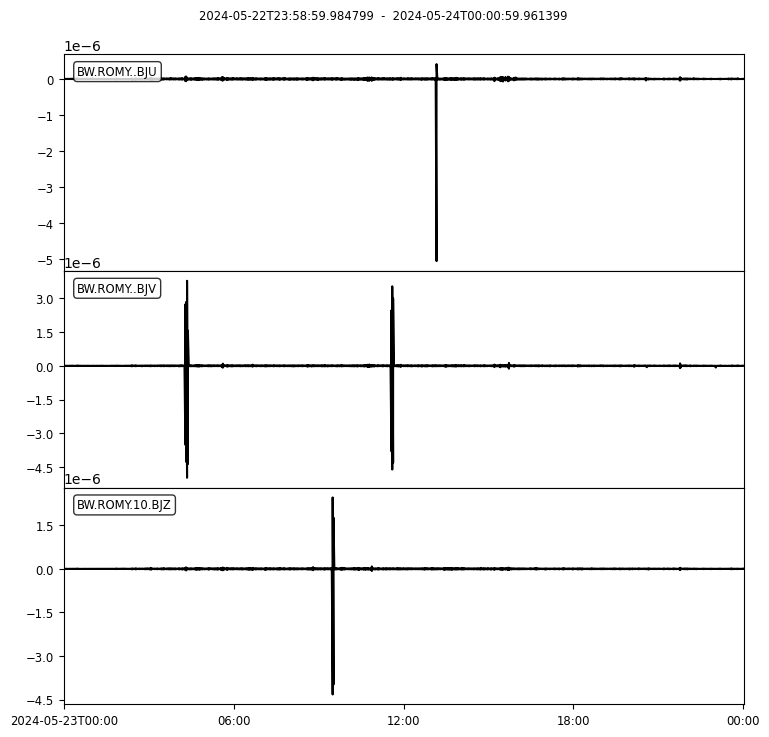

In [10]:
st0.plot(equal_scale=False);

In [11]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

In [12]:
tr_mltiU = __get_trace("BW.ROMY.30.MLT")

tr_mltiU.data = __mlti_intervals_to_zero(tr_mltiU.data,
                                         tr_mltiU.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiU_t1,
                                         mltiU_t2,
                                         t_offset_sec=60
                                         )

In [13]:
tr_mltiV = __get_trace("BW.ROMY.30.MLT")

tr_mltiV.data = __mlti_intervals_to_zero(tr_mltiV.data,
                                         tr_mltiV.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiV_t1,
                                         mltiV_t2,
                                         t_offset_sec=60
                                         )

In [14]:
tr_mltiZ = __get_trace("BW.ROMY.30.MLT")

tr_mltiZ.data = __mlti_intervals_to_zero(tr_mltiZ.data,
                                         tr_mltiZ.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiZ_t1,
                                         mltiZ_t2,
                                         t_offset_sec=60
                                         )

In [15]:
lxx_t1, lxx_t2 = __get_mlti_intervals(lxx.datetime)

In [16]:
tr_lxx = __get_trace("BW.ROMY.30.LXX")

tr_lxx.data = __mlti_intervals_to_zero(tr_lxx.data,
                                       tr_lxx.times(reftime=config['t1'], type="utcdatetime"),
                                       lxx_t1,
                                       lxx_t2,
                                       t_offset_sec=60
                                       )

In [17]:
# make mlti trace for horizontals (since rotated and intermixed)
tr_mltiH = tr_mltiU.copy()

# combine mlti periods
tr_mltiH.data += tr_mltiV.data

# remove periods with value 2 due to summation
tr_mltiH.data = where(tr_mltiH.data > 1, 1, tr_mltiH.data)

## Write Data

In [18]:
outZ = obs.Stream()

outZ += st0.select(component="Z")
outZ.select(component="Z")[0].stats.location = "30"
outZ += tr_mltiZ
outZ += tr_lxx

outZ = outZ.trim(config['tbeg'], config['tend'])

__write_stream_to_sds(outZ, "BJZ", config['path_to_sds_out'])


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/io/mseed/core.py:823: UserWarning: File will be written with more than one different record lengths.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'record lengths')


FileNotFoundError: [Errno 2] No such file or directory: '/home/andbro/freenas/temp_archive/2024/BW/ROMY/BJZ.D/BW.ROMY.30.BJZ.D.2024.144'

In [ ]:
outN = obs.Stream()

outN += st0.select(component="N")
outN.select(component="N")[0].stats.location = "30"
outN += tr_mltiH
outN += tr_lxx

outN = outN.trim(config['tbeg'], config['tend'])

__write_stream_to_sds(outZ, "BJN", config['path_to_sds_out'])


In [ ]:
outE = obs.Stream()

outE += st0.select(component="E")
outE.select(component="E")[0].stats.location = "30"
outE += tr_mltiH
outE += tr_lxx

outE = outE.trim(config['tbeg'], config['tend'])

__write_stream_to_sds(outZ, "BJE", config['path_to_sds_out'])


In [ ]:
plt.plot(outZ.select(component="Z")[0].data * outZ.select(channel="MLT")[0].data)